In [50]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#the above imports the plotting library matplotlib

In [159]:
#standard imports
import pymongo as pm
import numpy as np
import h5py
import scipy as sp
import scipy.stats as stats

#let's import the SVM classifier
from sklearn.svm import LinearSVC

#our own internal utility unctions
import metrics ; reload(metrics)
import cross_validation as cv; reload(cv)
import utils; reload(utils)
from utils import featurewise_norm, spearman_brown


In [5]:
#ok let's load the data 
DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)
objects = Ventral_Dataset['image_meta']['object_name'][:]   #array of object labels for all images --> shape == (5670,)
unique_objects = np.unique(objects)                      #array of unique object labels --> shape == (64,) 

objects_by_category = {c: np.unique(objects[categories == c]) 
                       for c in unique_categories}

Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]
IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS']
V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS']
V4_Neural_Data = Neural_Data[:, V4_NEURONS]
IT_Neural_Data = Neural_Data[:, IT_NEURONS]

var_level = Ventral_Dataset['image_meta']['variation_level'][:]

#use numpy recarray object to store metadata 
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())

In [3]:
HUMAN_DATA_PATH = "/mnt/data3/yamins/visual/human_behavior.hdf5"
Behavioral_Dataset = h5py.File(HUMAN_DATA_PATH)

In [165]:
expnames = [('Basic_categorization', 'category')] + \
            [(c + '_identification', 'obj') for c in unique_categories]
    
human_confmats = {}
for expname, exp_goal in expnames:
    if 'Basic' in expname:
        ucats = unique_categories
    else:
        catn = expname.split('_')[0]
        ucats = objects_by_category[catn]
    preds = Behavioral_Dataset[expname]['chosen']
    actuals = Behavioral_Dataset[expname]['actual']
    vls = Behavioral_Dataset[expname]['variation_level']
    cms = np.array([metrics.get_confusion_matrix(p, a, ucats) for p, a in zip(preds, actuals)])
    human_confmats[(expname, 'all')] = cms
    for v in ['V0', 'V3', 'V6']:
        cms = np.array([metrics.get_confusion_matrix(p[vl==v], a[vl==v], ucats) 
                             for p, a, vl in zip(preds, actuals, vls)])
        human_confmats[(expname, v)] = cms
                     

In [160]:
def idfunc(x):
    return x


def split_half_correlation(datas_by_trial, num_splits, aggfunc=idfunc, statfunc=stats.pearsonr):
    """
    """
        
    random_number_generator = np.random.RandomState(seed=0)

    corrvals = []
    for split_index in range(num_splits):
        stats1 = []
        stats2 = []
        for data in datas_by_trial:
            #get total number of trials
            num_trials = data.shape[0]

            #construct a new permutation of the trial indices
            perm = random_number_generator.permutation(num_trials)

            #take the first num_trials/2 and second num_trials/2 pieces of the data
            first_half_of_trial_indices = perm[:num_trials / 2]
            second_half_of_trial_indices = perm[num_trials / 2: num_trials]

            #mean over trial dimension
            s1 = aggfunc(data[first_half_of_trial_indices].mean(axis=0))
            s2 = aggfunc(data[second_half_of_trial_indices].mean(axis=0))
            stats1.extend(s1)
            stats2.extend(s2)
        
        #compute the correlation between the means
        corrval = statfunc(stats1, stats2)[0]
        #add to the list
        corrvals.append(corrval)
        
    return spearman_brown(np.array(corrvals), 2)

In [187]:
def get_split_half_from_cmatdict(confmat_dict, ks):
    corrvals = split_half_correlation([confmat_dict[k] for k in ks],
                       num_splits=100, 
                       aggfunc=metrics.dprime_confmat)
    return corrvals.mean()

In [151]:
pretty_good_cval = 1e-3
var_levels = ['all', 'V0', 'V3', 'V6']
        
def get_splits_and_labels(expname, exp_goal, vl):
    num_test = 10
    if vl == 'V0':
        num_test = 7
        num_train = 10 - num_test
    elif vl in ['V3', 'V6']:
        num_train = 40 - num_test
    else:
        num_train = 90 - num_test
    if exp_goal == 'category':
        if vl == 'all':
            train_filter = None
            test_filter = None
        else:
            train_filter = lambda x: (x['variation_level'] == vl)
            test_filter = lambda x: (x['variation_level'] == vl)

        labels = meta_array['category']
    else:
        catn = expname.split('_')[0]
        if vl == 'all':
            train_filter = lambda x: (x['category'] == catn)
            test_filter = lambda x: (x['category'] == catn)
        else:
            train_filter = lambda x: (x['variation_level'] == vl) and (x['category'] == catn)
            test_filter = lambda x: (x['variation_level'] == vl) and (x['category'] == catn)

        labels = meta_array['object_name']
        
    splits = cv.get_splits(metadata=meta_array, 
                           split_by_func=lambda x: x['object_name'],  #we're balancing splits by object
                           num_splits=5,  
                           num_per_class_test=num_test,  
                           num_per_class_train=num_train,
                           train_filter=train_filter,
                           test_filter=test_filter
                           )
   
    return splits, labels
    


In [152]:
neural_results = {}
for expname, exp_goal in expnames:
    neural_results[expname] = {}
    for vl in var_levels:
        print('Getting results for %s %s' % (expname, vl))
        splits, labels = get_splits_and_labels(expname, exp_goal, vl)
        neural_results[expname][vl] = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                     labels=labels,
                                     splits=splits,
                                     model_class=LinearSVC,
                                     model_args={'C': pretty_good_cval})
        acc = neural_results[expname][vl][0]['test']['mean_accuracy'] * 100
        print('Mean accuracy: %.2f' % acc)


Getting results for Basic_categorization all
Mean accuracy: 74.38
Getting results for Basic_categorization V0
Mean accuracy: 90.27
Getting results for Basic_categorization V3
Mean accuracy: 85.03
Getting results for Basic_categorization V6
Mean accuracy: 61.44
Getting results for Animals_identification all
Mean accuracy: 69.50
Getting results for Animals_identification V0
Mean accuracy: 83.21
Getting results for Animals_identification V3
Mean accuracy: 75.50
Getting results for Animals_identification V6
Mean accuracy: 52.25
Getting results for Boats_identification all
Mean accuracy: 57.50
Getting results for Boats_identification V0
Mean accuracy: 92.14
Getting results for Boats_identification V3
Mean accuracy: 55.50
Getting results for Boats_identification V6
Mean accuracy: 36.50
Getting results for Cars_identification all
Mean accuracy: 32.00
Getting results for Cars_identification V0
Mean accuracy: 61.79
Getting results for Cars_identification V3
Mean accuracy: 37.00
Getting results 

In [205]:
IT_neural_results = {}
for expname, exp_goal in expnames:
    IT_neural_results[expname] = {}
    for vl in var_levels:
        splits, labels = get_splits_and_labels(expname, exp_goal, vl)
        IT_neural_results[expname][vl] = cv.train_and_test_scikit_classifier(features=IT_Neural_Data, 
                                     labels=labels,
                                     splits=splits,
                                     model_class=LinearSVC,
                                     model_args={'C': pretty_good_cval})
        
V4_neural_results = {}
for expname, exp_goal in expnames:
    V4_neural_results[expname] = {}
    for vl in var_levels:
        splits, labels = get_splits_and_labels(expname, exp_goal, vl)
        V4_neural_results[expname][vl] = cv.train_and_test_scikit_classifier(features=V4_Neural_Data, 
                                     labels=labels,
                                     splits=splits,
                                     model_class=LinearSVC,
                                     model_args={'C': pretty_good_cval})

In [207]:
neural_confmats = {}
IT_neural_confmats = {}
V4_neural_confmats = {}
for expname, exp_goal in expnames:
    for vl in var_levels:
        neural_confmats[(expname, vl)] = \
             neural_results[expname][vl][0]['test']['confusion_matrices']
        IT_neural_confmats[(expname, vl)] = \
             IT_neural_results[expname][vl][0]['test']['confusion_matrices']
        V4_neural_confmats[(expname, vl)] = \
             V4_neural_results[expname][vl][0]['test']['confusion_matrices']            

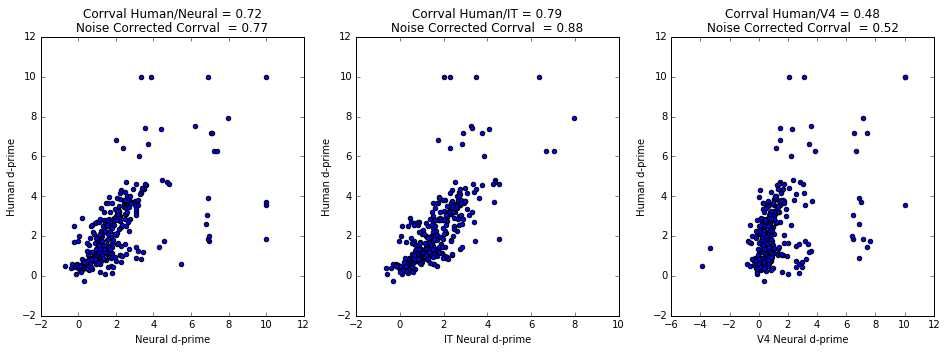

In [209]:
#keys = [x for x in human_confmats.keys() if 'Basic' in x[0]]
#keys = [x for x in human_confmats.keys() if x[1] in ['V3', 'V6']]
#keys = [x for x in human_confmats.keys() if 'Basic' not in x[0] and x[1] in ['V3', 'V6']]
keys = human_confmats.keys()

d_neural = []
d_it = []
d_v4 = []
d_human = []
for k in keys:
    neural_dprime = metrics.dprime_confmat(neural_confmats[k].mean(0))
    it_neural_dprime = metrics.dprime_confmat(IT_neural_confmats[k].mean(0))
    v4_neural_dprime = metrics.dprime_confmat(V4_neural_confmats[k].mean(0))
    human_dprime = metrics.dprime_confmat(human_confmats[k].mean(0))
    d_neural.extend(neural_dprime)   
    d_it.extend(it_neural_dprime)  
    d_v4.extend(v4_neural_dprime)  
    d_human.extend(human_dprime)

human_splithalf = get_split_half_from_cmatdict(human_confmats, keys) 
neural_splithalf = get_split_half_from_cmatdict(neural_confmats, keys) 
it_neural_splithalf = get_split_half_from_cmatdict(IT_neural_confmats, keys) 
v4_neural_splithalf = get_split_half_from_cmatdict(V4_neural_confmats, keys) 

plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.scatter(d_neural, d_human)
corrval = stats.spearmanr(d_neural, d_human)[0]
corrected_corrval = corrval / np.sqrt(human_splithalf * neural_splithalf)
plt.title('Corrval Human/Neural = %.2f\nNoise Corrected Corrval  = %.2f' % (corrval, corrected_corrval))
plt.xlabel('Neural d-prime'); plt.ylabel('Human d-prime')

plt.subplot(1, 3, 2)
plt.scatter(d_it, d_human)
corrval = stats.spearmanr(d_it, d_human)[0]
corrected_corrval = corrval / np.sqrt(human_splithalf * it_neural_splithalf)
plt.title('Corrval Human/IT = %.2f\nNoise Corrected Corrval  = %.2f' % (corrval, corrected_corrval))
plt.xlabel('IT Neural d-prime'); plt.ylabel('Human d-prime')

plt.subplot(1, 3, 3)
plt.scatter(d_v4, d_human)
corrval = stats.spearmanr(d_v4, d_human)[0]
corrected_corrval = corrval / np.sqrt(human_splithalf * v4_neural_splithalf)
plt.title('Corrval Human/V4 = %.2f\nNoise Corrected Corrval  = %.2f' % (corrval, corrected_corrval))
plt.xlabel('V4 Neural d-prime'); plt.ylabel('Human d-prime')
